In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc

from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [2]:
snap = 122
nbins = 10
bin = 9
r = HBTReader("./data/")

### Subhalo mass function

In [3]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[30618 28023 22296 15433 10387  6412  3711  2403  1366   850   491   283
   170    84    50    32    10     8     3     4] [ 1.30103     1.55090953  1.80078906  2.05066858  2.30054811  2.55042764
  2.80030717  3.0501867   3.30006623  3.54994576  3.79982529  4.04970482
  4.29958435  4.54946388  4.79934341  5.04922294  5.29910247  5.548982
  5.79886153  6.04874106  6.29862059] [ 1.42596976  1.67584929  1.92572882  2.17560835  2.42548788  2.67536741
  2.92524694  3.17512647  3.425006    3.67488553  3.92476506  4.17464459
  4.42452412  4.67440365  4.92428318  5.17416271  5.42404224  5.67392177
  5.9238013   6.17368083]


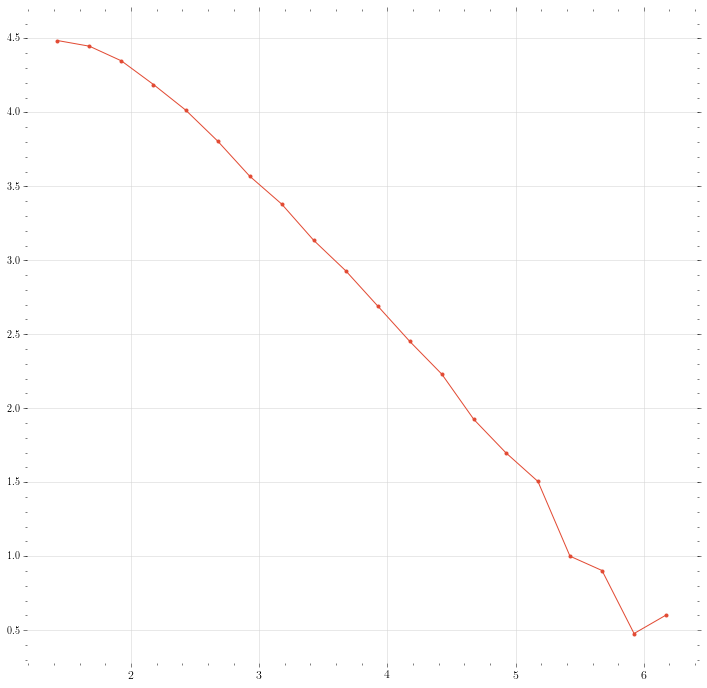

In [4]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [5]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
hs = hs[hs['M200Crit'] >= 20]
hs['M200Crit'] = 1e10*hs['M200Crit']

counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[1698  955  518  260  154   65   34   16    4    5] [ 11.3013382   11.61354208  11.92574596  12.23794985  12.55015373
  12.86235762  13.1745615   13.48676538  13.79896927  14.11117315
  14.42337704] [ 11.45744014  11.76964402  12.08184791  12.39405179  12.70625567
  13.01845956  13.33066344  13.64286733  13.95507121  14.26727509]


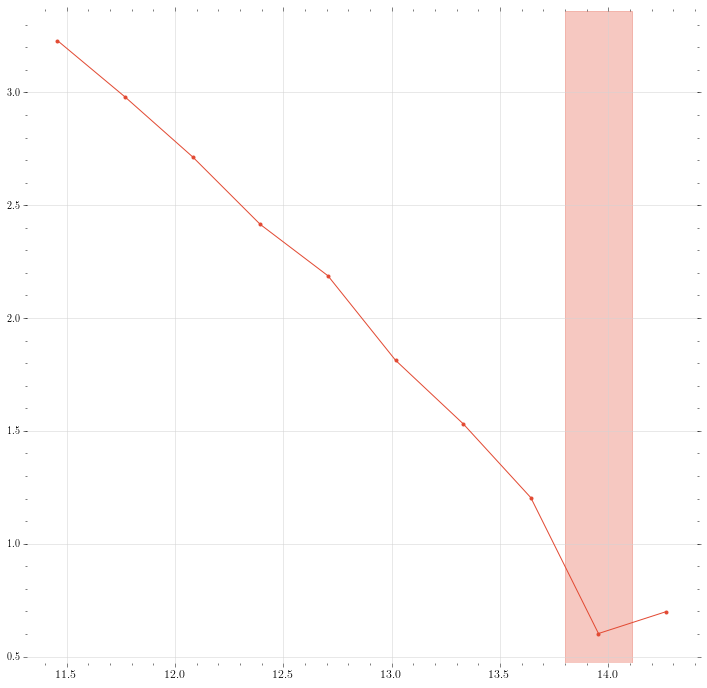

In [6]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

In [7]:
hs = hs[hs['bin'] == bin]

### Density profile

In [8]:
ps = np.array(r.LoadHostHalos(snap, [list(hs['HaloId']),])['Profile'],\
    dtype=np.float)
xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
particles = np.sum(ps, axis=1)
ps = np.divide(ps.T, np.sum(ps, axis=1)).T
p = np.median(ps, axis=0)
x = np.linspace(-2.0, 0.0, 20)
vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

In [9]:
xmax = 0.8
idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))
# c = nfw.fit(p, lambda c: nfw.m(np.power(10.0, x), c),\
#     np.linspace(1.0, 10.0, 100))
# rho_s = np.log10(nfw.rho_enc(1.0/c, c))
c, a = einasto.fit(p, lambda c, a: einasto.m(np.power(10.0, x), c, a),\
    np.linspace(1.0, 10.0, 100), np.linspace(0.01, 0.99, 100))
rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

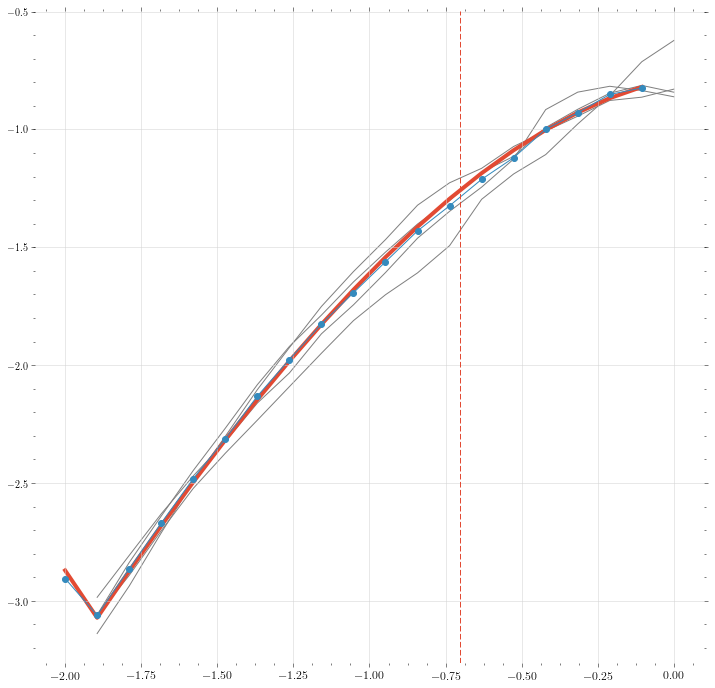

In [10]:
plt.plot(x[idx], np.log10(einasto.m(np.power(10.,x), c, a)[idx]),\
    color='C0', linewidth=4, zorder=1)

[plt.plot(x[1:], np.log10(_[1:]), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')

### Collapsed Mass History

In [11]:
# F = nfw.m_enc(1.0/c, c)
F = einasto.m_enc(1.0/c, c, a)
print F

0.204460758767


In [12]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = read.snaps()
# np.genfromtxt('./output/hbtp/redshift_list.txt',\
#     dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['Snapshot'] == s][0]['Redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

In [13]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

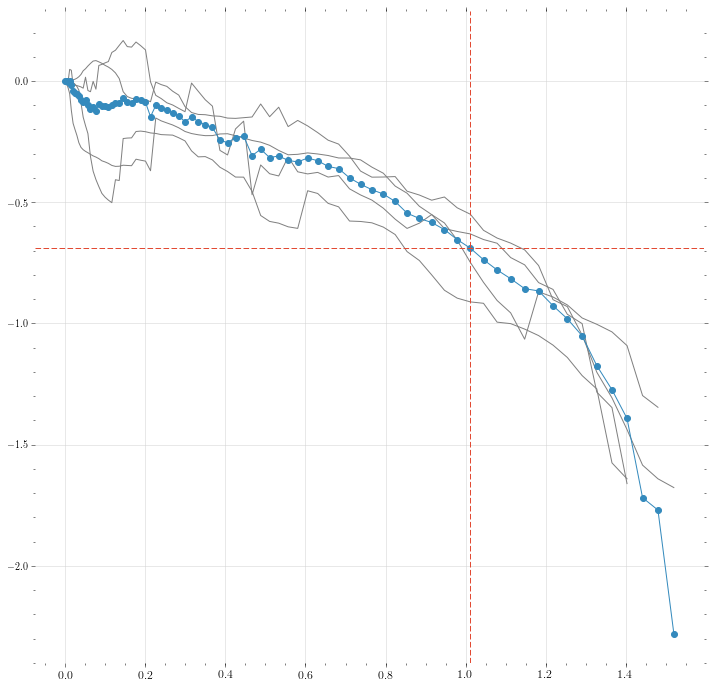

In [14]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation.

In [15]:
rho_f, rho_s

(1.0113295318453088, 3.7202351084794807)

In [16]:
ds = {g: np.genfromtxt('/gpfs/data/dc-oles1/merger_trees/output/%s/rhof_rhos.csv'%g,\
    delimiter=',', skip_header=1, dtype=np.dtype([\
    ('snap',int),\
    ('bin',int),\
    ('rho_f',float),\
    ('rho_s',float),\
])) for g in ['gr', 'fr']}

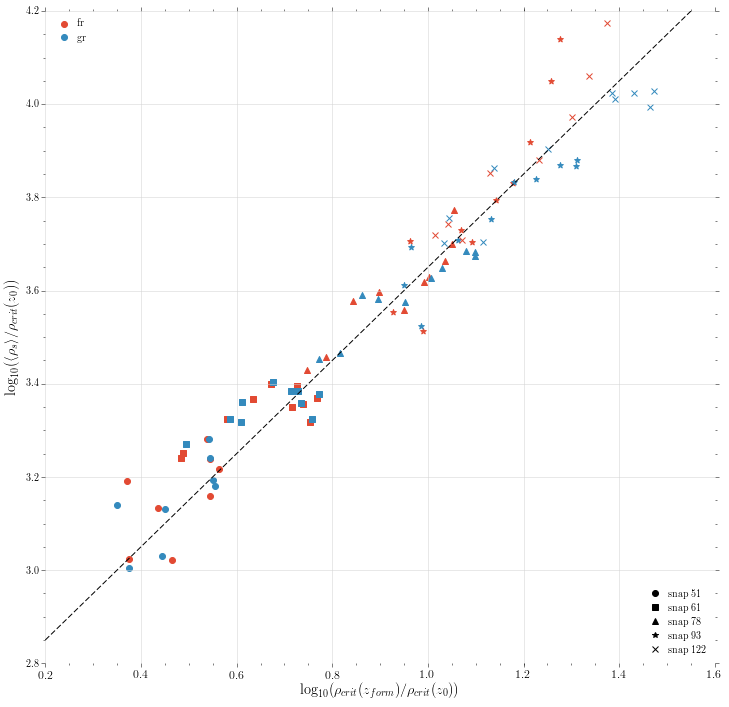

In [19]:
markers = [['o', None], ['s', None], ['^', None], ['*', None], ['x', None]]
colours = [['C0', None], ['C1', None]]

for i,snap in enumerate(np.unique(ds['gr']['snap'])):
    for j,g in enumerate(ds):
        for d in ds[g][ds[g]['snap'] == snap]:
            plt.scatter(d['rho_f'], d['rho_s'],\
                color=colours[j][0], marker=markers[i][0])
            markers[i][1] = plt.Line2D([], [], label='snap %d'%snap,\
                color='k', marker=markers[i][0], linestyle='')
        colours[j][1] = plt.Line2D([], [], label=g,\
            color=colours[j][0], marker='o', linestyle='')
# colours[1][1] = plt.Line2D([], [], label='f(R)',\
#     color=colours[0], linestyle='')

plt.plot(np.linspace(0.2, 1.6), 2.65+np.linspace(0.2, 1.6), 'k--')
plt.xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
plt.ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
plt.xlim((0.2, 1.6))
plt.ylim((2.8, 4.2))

l1 = plt.legend(handles=[markers[i][1] for i in range(len(markers))], loc='lower right')
l2 = plt.legend(handles=[colours[j][1] for j in range(len(colours))], loc='upper left')
plt.gca().add_artist(l1)